## Remark ##
In order to visualise the notebook correctly without running it you can go to the following url: http://www.student.montefiore.ulg.ac.be/~s131697/ADA/HW3.html

In [33]:
%matplotlib inline


import os
import pandas as pd
import json
import folium
import matplotlib.pyplot as plt

import branca

# Question 1

Go to the eurostat website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a Choropleth map which shows the unemployment rate in Europe at a country level. Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

We found a tsv file containing the most recent values on unemployment rate in Europe. We then parsed it, kept the most recent values (2016) and created a map with these values. We then used topojson to get the map of Europe and then created a choropleth map with those two maps. We decided to use a variation of yellow-red to show that the "redder" a country is, the worse it the unemployment rate (red being usually associated with "bad" things). The countries without any data are colored black. We decided to set the scale to decades.    
We expect southern countries to have worse unemployment rates, as it is somewhat "known". Switzerland and Germany should have good rates according to the media.

In [34]:
eu_geo_path = r'topojson/europe.topojson.json'
geo_json_data = json.load(open(eu_geo_path))

In [35]:
def style_function_eu(feature):
    employed = unemployment_df[unemployment_df["geo\\time"] == feature['id']]
    if employed.empty:    
        return {
            'fillOpacity': .5,
            'weight': 0,
            'fillColor': '#black'
        }
    return {}

In [36]:
m_eu = folium.Map([50.85, 4.35], zoom_start=3)

colorscale = branca.colormap.linear.PuRd.scale(0, 1)
unemployment_df = pd.read_csv('data/tesem010.tsv', sep='\t|,', engine='python')
unemployment_df.sort_index().head()
unemployment_df = unemployment_df[unemployment_df.sex == 'T']
unemployment_df = unemployment_df[['geo\\time','2016']]
unemployment_df['2016'] = 100.0 - unemployment_df['2016'].astype(str).str.replace('b', '').astype(float)
unemployment_df.head()
unemployment_df['geo\\time'] = unemployment_df['geo\\time'].astype(str).str.replace('UK', 'GB').replace('EL', 'GR')

m_eu.choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=unemployment_df,
    columns=['geo\\time','2016'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)',
    topojson='objects.europe',
    threshold_scale=range(0,60,10)
)

folium.TopoJson(
    geo_json_data,
    'objects.europe',
    style_function=style_function_eu
).add_to(m_eu)

m_eu

As expected, the southern countries are worse and Switzerland is in a very good position (Sweden as well). Surprisingly, Turkey has a huge unemployment rate.    
We can also see that the eastern countries also have quite big unemployment rates. We do not have statistics however for the eastern-most countries.

# Question 2

Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

We used the Swiss cantons topography as a base, and then used the september 2017 unemployment dataset to create a DataFrame, renamed the index to use the cantons abbreviation and created a new column for the rate without the persons looking for a job while still having a job (which doesn't really sound like unemployment actually)

In [37]:
ch_geo_path = r'topojson/ch-cantons.topojson.json'
geo_json_data_ch = json.load(open(ch_geo_path))

In [38]:
unem_ch_glob_data = r'data/unem_ch_glob_sept_2017.xlsx'
unem_ch_glob_df = pd.read_excel(unem_ch_glob_data, header=[3], skip_footer=1, index_col=None)
unem_ch_glob_df = unem_ch_glob_df[unem_ch_glob_df.columns[1:5]]

unem_ch_glob_df.index = ['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW',
                           'GL', 'ZG', 'FR', 'SO', 'BS', 'BL',
                           'SH', 'AR','AI', 'SG', 'GR', 'AG',
                           'TG', 'TI', 'VD', 'VS', 'NE', 'GE', 'JU']
unem_ch_glob_df.index.name = 'Canton'

unem_ch_glob_df.columns = ['Total_rate', 'Subscribed', 'Look_for_job', 'Look_for_job_with_job']

# Multiply the total ratio by the ratio of people subscribed over all the people looking for a job.
unem_ch_glob_df['Rate_without_with_job'] = unem_ch_glob_df['Total_rate'] * \
(unem_ch_glob_df['Subscribed'] / unem_ch_glob_df['Look_for_job'])

## 2.1
We then plot the map with the topography and the data computed just above.

In [39]:
m_ch = folium.Map([46.8182, 8.2275], zoom_start=8)

m_ch.choropleth(
    geo_data=geo_json_data_ch,
    name='choropleth',
    data=unem_ch_glob_df['Total_rate'],
    columns=['Canton', 'Total_rate'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)',
    topojson='objects.cantons',
    highlight=True,
    threshold_scale=[0,1.5,2.5,3.5,4.5,5.5]
)

m_2 = m_ch
m_ch

## 2.2
Same process as before, we just show a different column on the map. We use the same scale as before, for easier comparisons.

In [40]:
m_ch = folium.Map([46.8182, 8.2275], zoom_start=8)

m_ch.choropleth(
    geo_data=geo_json_data_ch,
    name='choropleth',
    data=unem_ch_glob_df['Rate_without_with_job'],
    columns=['Canton', 'Total_rate'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)',
    topojson='objects.cantons',
    threshold_scale=[0,1.5,2.5,3.5,4.5,5.5]
)

m_ch

# Question 3

Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

### Canton Chloropeth map ###
In order to be able to compare the employment rates, the maps are plotted next to each other.     
We tried to use a map with two layers, but the legends didn't disappear while changing the layer, which was not very practical.

In [41]:
import numpy as np
from branca.utilities import split_six

unem_ch_sep_data = r'data/unem_ch_sep_nat_sept_2017.xlsx'
unem_ch_sep_df = pd.read_excel(unem_ch_sep_data, header=[3], skip_footer=1)
unem_ch_sep_df = unem_ch_sep_df[unem_ch_sep_df.columns[1:2]]


unem_ch_sep_df = unem_ch_sep_df.unstack(level=1)
unem_ch_sep_df.index = ['AR','AI','AG','BE','BL','BS','FR','GE','GL',
                        'GR','JU','LU','NE','NW','OW','SH','SZ','SO',
                        'SG','TI','TG','UR','VS','VD','ZG','ZH']
unem_ch_sep_df.index.name = 'Canton'

m_ch_foreign = folium.Map([46.8182, 8.2275], zoom_start=7)

arr = unem_ch_sep_df['Taux de chômage']['Etrangers']\
                            .append(unem_ch_sep_df['Taux de chômage']['Suisses'])
threshold_scale = [np.percentile(arr, x) for x in [0, 25, 50, 75, 100]]

m_ch_foreign.choropleth(
    geo_data=geo_json_data_ch,
    name='Foreigners Unemployment',
    data=unem_ch_sep_df['Taux de chômage']['Etrangers'],
    columns=['Canton', 'Etrangers'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Foreigners Unemployment Rate (%)',
    topojson='objects.cantons',
    threshold_scale=threshold_scale
)

m_ch_foreign.save('foreigners_unemployment_ch.html')

m_ch_local = folium.Map([46.8182, 8.2275], zoom_start=7)

m_ch_local.choropleth(
    geo_data=geo_json_data_ch,
    name='Locals Unemployment',
    data=unem_ch_sep_df['Taux de chômage']['Suisses'],
    columns=['Canton', 'Locals'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Locals Unemployment Rate (%)',
    topojson='objects.cantons',
    threshold_scale=threshold_scale
)

m_ch_local.save('locals_unemployment_ch.html')

In order to ease the comparison of the maps the same legend scale has been used for the 2 maps. The first thing easily noticeable is that the unemployment rate is well higher in every canton in the foreigner population than in the local one except for Geneva. We also notice that for both locals and foreigners the unemployment rate is higher in the west of the country than in the east. Geneva seems to be the black duck for the locals unemployment rate whereas the jura is the one for the foreigners.     
To be able to push deeper the analysis we need a map which directly compares the two rates : this is done in the next cell.

In [42]:
%%html
<iframe src='http://www.student.montefiore.ulg.ac.be/~s131697/ADA/foreigners_unemployment_ch.html' width='50%' height='300' ></iframe><iframe src='http://www.student.montefiore.ulg.ac.be/~s131697/ADA/locals_unemployment_ch.html' width='50%' height='300' /></iframe>

In [43]:
unem_ch_sep_df['ratio'] = unem_ch_sep_df['Taux de chômage']['Etrangers']/unem_ch_sep_df['Taux de chômage']['Suisses']

m_ch_local = folium.Map([46.8182, 8.2275], zoom_start=8)

m_ch_local.choropleth(
    geo_data=geo_json_data_ch,
    name='Ratio of Unemployment',
    data=unem_ch_sep_df['ratio'],
    columns=['Canton', 'Locals'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Ratio of Unemployment Rates(Foreigner/Local)',
    topojson='objects.cantons'
)

Thanks to this map it is possible to compare easily the two rates of unemployment. 

First we see that in Neuchâtel, Vaud and Geneva the unemployment rate in foreigners is almost the same as the unemployment rate of swiss people. However it is worth also noting that these cantons are the one with the higher unemployment rate when we do not consider the origin of people(see map 2.2).

On the other extreme the central cantons (Uri, Obwalden and Nidwalden) unemployment rate of foreign people is well higher than the unemployment rate of swiss people. It is also worth noting that these cantons have the loweest unemployment rate of the country. 

On the overall map we see that the foreigners unemployment is well higher than it is for the swiss population (as much as five times higher). We also see that the extreme values (very high or very low difference) are in the cantons having extreme values in terms of overall unemployment rate.

In [44]:
m_ch_local

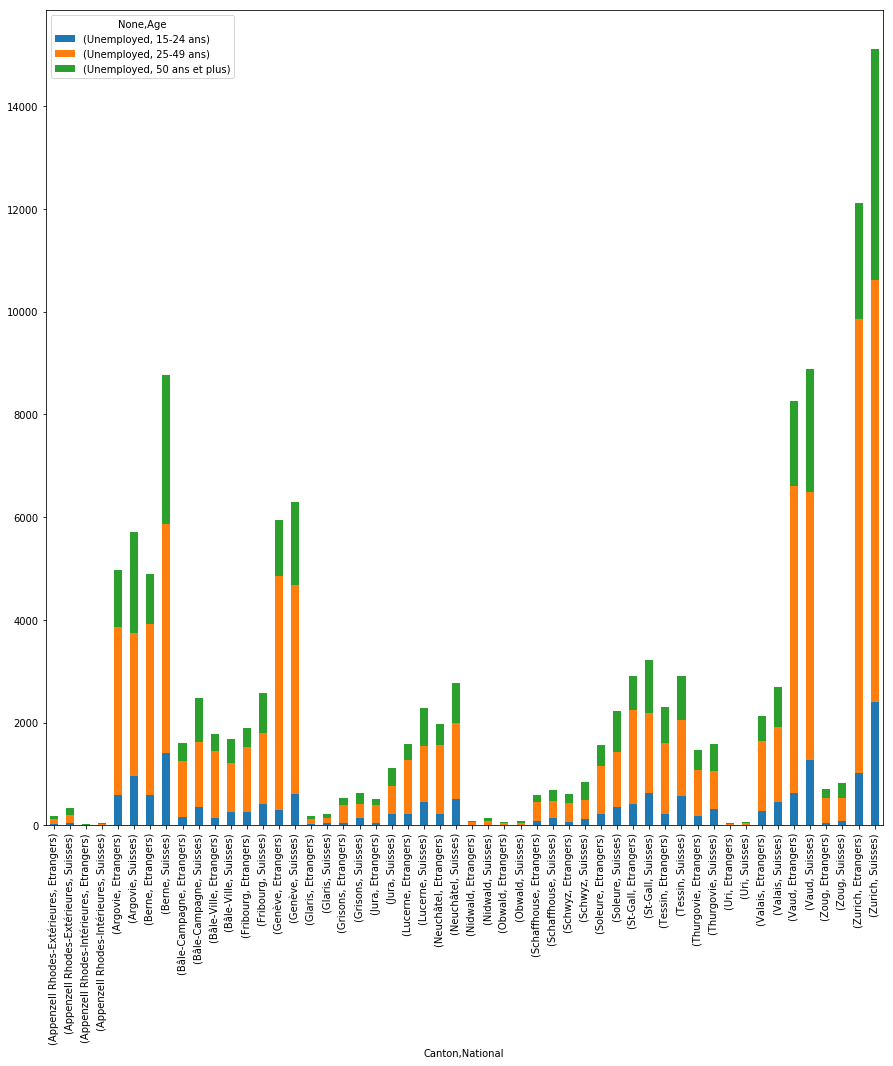

In [59]:
unem_ch_sep_nat_age_data = r'data/unem_ch_sep_age_nat_sept_2017.xlsx'
unem_ch_sep_nat_age_data_df = pd.read_excel(unem_ch_sep_nat_age_data, skiprows=3, usecols=[0,1,3,5], skip_footer=1)
unem_ch_sep_nat_age_data_df.columns = ['Canton', 'National', 'Age', 'Unemployed']

#unem_ch_sep_nat_age_data_df['joined_nat_age'] = unem_ch_sep_nat_age_data_df['National'] + "_" + unem_ch_sep_nat_age_data_df['Age']
#unem_ch_sep_nat_age_data_df.drop(['National','Age'], axis=1, inplace=True)

unem_ch_sep_nat_age_data_df = unem_ch_sep_nat_age_data_df.drop(unem_ch_sep_nat_age_data_df.index[range(8,len(unem_ch_sep_nat_age_data_df),9)])
unem_ch_sep_nat_age_data_df = unem_ch_sep_nat_age_data_df.reset_index()


total_per_canton = unem_ch_sep_nat_age_data_df.iloc[range(3,len(unem_ch_sep_nat_age_data_df),4)]

remain = unem_ch_sep_nat_age_data_df[ (1 + unem_ch_sep_nat_age_data_df.index) % 4 != 0]
remain = remain.drop(['index'],axis=1)
remain = remain.set_index(['Canton','National','Age']).unstack(['Age'])
fig, ax = plt.subplots(figsize=(15,15))
remain.plot.bar(stacked=True, ax=ax)

#unem_ch_sep_nat_age_data_df = unem_ch_sep_nat_age_data_df[unem_ch_sep_nat_age_data_df.columns[2:3]]

#unem_ch_sep_nat_age_data_df = unem_ch_sep_nat_age_data_df.unstack(level=1)



## BONUS ##
Using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

Using the map constructed in the part 2.2 we directly notice that the employment rate in french speaking part of the country is higly higher than it is in the german speaking one. The unemployment rate of french speaking part must be somewhere between 2.5 and 4 percent, probably somewhere around 3 percent. On the german speaking part the unemployment rate is somewhere between 1 and 2 percent. 

In [46]:
m_ch